In [ ]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
! conda install -c rdkit rdkit -y

! pip install chembl_webresource_client
! pip install molvs
! pip install deepchem

--2022-04-02 07:06:01--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   299MB/s    in 0.3s    

2022-04-02 07:06:01 (299 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

PART 1: 数据准备

In [ ]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

# Import necessary libraries
import pandas as pd
import pandas as pd
import molvs as mv
from molvs.standardize import standardize_smiles
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
#from rdkit.Chem import Descriptors, Lipinski
import numpy as np
from rdkit.Chem import Crippen, Descriptors, Lipinski
import matplotlib
import matplotlib.pyplot as plt


In [ ]:
target = new_client.target
target_query = target.search('acetylcholinesterase')
targets = pd.DataFrame.from_dict(target_query)
selected_target = targets.target_chembl_id[0]

activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

In [ ]:
df.shape

(8205, 45)

In [ ]:
df.to_csv('chembl_acetylcholinesterase_bioactivity_data_raw_20220401.csv', index=False)

In [ ]:
# neutralize the molecules
def un_charge_molecule(smi):
    try:
        un = rdMolStandardize.Uncharger()
        mol = Chem.MolFromSmiles(smi)
        un_mol = un.uncharge(mol)
        res_smi = Chem.MolToSmiles(un_mol)
        return res_smi
    except:
        return "NaN"
    
# remove trival molecules
def choose_largest_frag(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        # setup standardization module
        largest_Fragment = rdMolStandardize.LargestFragmentChooser()
        largest_mol = largest_Fragment.choose(mol)
        smi_res = Chem.MolToSmiles(largest_mol)
        return smi_res
    except:
        print("%s failed conversion"%smi)
        return "NaN"

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

# get_descriptors
def get_descriptors(smi_list):
  des_list = []
  mol_objs = [Chem.MolFromSmiles(item) for item in smi_list]
  mws = [Descriptors.MolWt(m) for m in mol_objs]
  logps = [Chem.Crippen.MolLogP(m) for m in mol_objs]
  hbas = [Chem.Lipinski.NumHAcceptors(m) for m in mol_objs]
  hbds = [Chem.Lipinski.NumHDonors(m) for m in mol_objs]
  tpsas = [Descriptors.TPSA(m) for m in mol_objs]
  des_df = pd.DataFrame([mws, logps, hbas, hbds, tpsas]).T
  des_df.columns = ['MW', 'LogP', 'Hba', 'Hbd', 'TPSA']
  return des_df


# IC50 to pIC50
def pIC50(input):
  input_new = float(input)
  molar = input_new*(10**-9)
  pIC50_val = -np.log10(molar)
  if pIC50_val > 9:
    pIC50_val = 9
  return pIC50_val

# add class info
def pic50_to_2class(pic50):
    if pic50 < 7:
        return 0
    else:
        return 1

In [ ]:
df2 = df[df.standard_value.notna()]
print(df2.shape)
df2 = df2[df.canonical_smiles.notna()]
print(df2.shape)
df2 = df2[df2['assay_type']=='B']
print(df2.shape)
df2 = df2[df2['standard_relation']=='=']
print(df2.shape)
df2 = df2[df2['standard_units']=='nM']
print(df2.shape)

df2['canonical_smiles'] = df2['canonical_smiles'].apply(standardize_smiles)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(un_charge_molecule)
df2['canonical_smiles'] = df2['canonical_smiles'].apply(choose_largest_frag)

(6949, 45)
(6947, 45)
(6792, 45)
(6115, 45)
(6093, 45)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df2_activity_sub = df2[df2['bao_label']=='single protein format']
df2_activity_sub_nr = df2_activity_sub.drop_duplicates(['canonical_smiles'])
df2_activity_sub_nr.reset_index(drop=True, inplace=True)
df3 = df2_activity_sub_nr[['molecule_chembl_id','canonical_smiles', 'standard_type', 'standard_relation', 'standard_value', 'standard_units']]


In [ ]:
df3

,molecule_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,=,750.0,nM
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,=,100.0,nM
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,IC50,=,300.0,nM
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,IC50,=,800.0,nM
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,IC50,=,2400.0,nM
...,...,...,...,...,...,...
4000,CHEMBL3982580,COc1cccc2c1C=[N+](c1ccc(Br)cc1Br)CC2,IC50,=,3720.0,nM
4001,CHEMBL3979102,COc1cccc2c1C=[N+](c1ccc(Br)cc1F)CC2,IC50,=,1290.0,nM
4002,CHEMBL3900117,COc1cccc2c1C=[N+](c1ccc(I)cc1F)CC2,IC50,=,1060.0,nM
4003,CHEMBL4779440,Brc1ccc([N+]2=Cc3ccccc3CC2)cc1,IC50,=,10500.0,nM


In [ ]:
descriptors = get_descriptors(df3.canonical_smiles)

In [ ]:
descriptors

,MW,LogP,Hba,Hbd,TPSA
0,312.325,2.80320,6.0,0.0,66.49
1,376.913,4.55460,5.0,0.0,51.02
2,404.845,4.70690,5.0,0.0,51.02
3,346.334,3.09530,6.0,0.0,60.25
4,338.436,4.07992,5.0,0.0,51.02
...,...,...,...,...,...
4000,396.102,4.53940,1.0,0.0,12.24
4001,335.196,3.91600,1.0,0.0,12.24
4002,382.196,3.75810,1.0,0.0,12.24
4003,287.180,3.76830,0.0,0.0,3.01


In [ ]:
df3_w_druglike = pd.concat([df3,descriptors], axis=1)
df3_w_druglike = df3_w_druglike[(df3_w_druglike['MW'] < 800) & (df3_w_druglike['MW'] > 150)]
df3_w_druglike = df3_w_druglike[(df3_w_druglike['LogP'] < 8) & (df3_w_druglike['LogP'] > -5)]
df3_w_druglike = df3_w_druglike[df3_w_druglike['Hbd'] <= 8]
df3_w_druglike = df3_w_druglike[df3_w_druglike['Hba'] <= 10]
df3_w_druglike = df3_w_druglike[df3_w_druglike['TPSA'] <= 160]

In [ ]:
df3_w_druglike['pIC50'] = df3_w_druglike['standard_value'].apply(pIC50)
df3_w_druglike['Classification'] = df3_w_druglike['pIC50'].apply(pic50_to_2class)
df_final = df3_w_druglike.reset_index(drop=True)
df_final

,molecule_chembl_id,canonical_smiles,standard_type,standard_relation,standard_value,standard_units,MW,LogP,Hba,Hbd,TPSA,pIC50,Classification
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,IC50,=,750.0,nM,312.325,2.80320,6.0,0.0,66.49,6.124939,0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,IC50,=,100.0,nM,376.913,4.55460,5.0,0.0,51.02,7.000000,1
2,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,IC50,=,300.0,nM,404.845,4.70690,5.0,0.0,51.02,6.522879,0
3,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,IC50,=,800.0,nM,346.334,3.09530,6.0,0.0,60.25,6.096910,0
4,CHEMBL130112,CSc1nc(-c2ccc(C)cc2)nn1C(=O)N(C)c1ccccc1,IC50,=,2400.0,nM,338.436,4.07992,5.0,0.0,51.02,5.619789,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,CHEMBL3982580,COc1cccc2c1C=[N+](c1ccc(Br)cc1Br)CC2,IC50,=,3720.0,nM,396.102,4.53940,1.0,0.0,12.24,5.429457,0
3747,CHEMBL3979102,COc1cccc2c1C=[N+](c1ccc(Br)cc1F)CC2,IC50,=,1290.0,nM,335.196,3.91600,1.0,0.0,12.24,5.889410,0
3748,CHEMBL3900117,COc1cccc2c1C=[N+](c1ccc(I)cc1F)CC2,IC50,=,1060.0,nM,382.196,3.75810,1.0,0.0,12.24,5.974694,0
3749,CHEMBL4779440,Brc1ccc([N+]2=Cc3ccccc3CC2)cc1,IC50,=,10500.0,nM,287.180,3.76830,0.0,0.0,3.01,4.978811,0


In [ ]:
df_final.to_csv('chembl_acetylcholinesterase_bioactivity_data_processed_20220401.csv', index=False)

Text(0.5, 1.0, 'chembl_ach_TPSA')

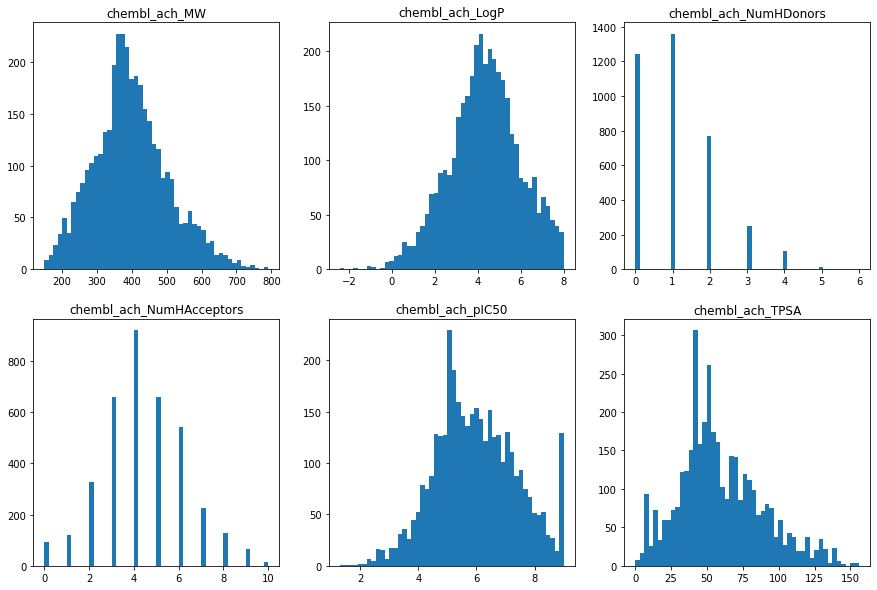

In [ ]:
# data plotting: before split
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import deepchem as dc

data = pd.read_csv('chembl_acetylcholinesterase_bioactivity_data_processed_20220401.csv')
fig=plt.figure(figsize=(15,10))
ax1=fig.add_subplot(2,3,1)
ax1.hist(data['MW'], bins=50)
plt.title('chembl_ach_MW')

ax1=fig.add_subplot(2,3,2)
ax1.hist(data['LogP'], bins=50)
plt.title('chembl_ach_LogP')

ax1=fig.add_subplot(2,3,3)
ax1.hist(data['Hbd'], bins=50)
plt.title('chembl_ach_NumHDonors')

ax1=fig.add_subplot(2,3,4)
ax1.hist(data['Hba'], bins=50)
plt.title('chembl_ach_NumHAcceptors')

ax1=fig.add_subplot(2,3,5)
ax1.hist(data['pIC50'], bins=50)
plt.title('chembl_ach_pIC50')

ax1=fig.add_subplot(2,3,6)
ax1.hist(data['TPSA'], bins=50)
plt.title('chembl_ach_TPSA')

#ax1=fig.add_subplot(2,3,6)
#counts = data['Classification'].value_counts()
#ax1.bar(counts.index, counts.values)
#plt.title('chembl_ach_Class')

In [ ]:
import deepchem as dc
import pandas as pd
import os


# pandas read file
original_data = pd.read_csv('chembl_acetylcholinesterase_bioactivity_data_processed_20220401.csv')
#original_data_sub = original_data[['mol', 'CID', 'Class', 'pIC50']]
# deepchem read file
input_data='chembl_acetylcholinesterase_bioactivity_data_processed_20220401.csv'
tasks=['Classification']
featurizer=dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(tasks=tasks, feature_field='canonical_smiles',featurizer=featurizer)
dataset=loader.create_dataset(input_data)
# splitters
scaffoldsplitter = dc.splits.ScaffoldSplitter()
# split data
train_dataset, test_dataset = scaffoldsplitter.train_test_split(dataset)
# train data get smiles
train_dataset_df = train_dataset.to_dataframe()
train_dataset_df_sub = train_dataset_df[['ids']]
train_dataset_df_sub.columns = ['smiles']
# train data merge
merged_train_data = pd.merge(train_dataset_df_sub, original_data, how='inner', left_on='smiles', right_on='canonical_smiles', left_index=False, right_index=False)
merged_train_data.to_csv('chembl_ach_train_scaffoldsplitter_20220401.csv', index=False)
# test data get smiles
test_dataset_df = test_dataset.to_dataframe()
test_dataset_df_sub = test_dataset_df[['ids']]
test_dataset_df_sub.columns = ['smiles']
# test data merge
merged_test_data = pd.merge(test_dataset_df_sub, original_data, how='inner', left_on='smiles', right_on='canonical_smiles', left_index=False, right_index=False)
merged_test_data.to_csv('chembl_ach_test_scaffoldsplitter_20220401.csv', index=False)

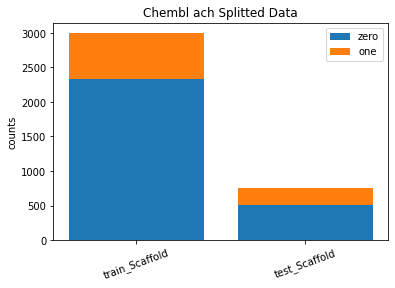

In [ ]:
# data plotting: after split
test_Scaffold = pd.read_csv('chembl_ach_test_scaffoldsplitter_20220401.csv')
train_Scaffold = pd.read_csv('chembl_ach_train_scaffoldsplitter_20220401.csv')

fig, ax = plt.subplots()
ax.xaxis.set_tick_params(rotation=20)

labels = ['train_Scaffold', 'test_Scaffold'] 
zero_Classification = [train_Scaffold['Classification'].value_counts()[0], test_Scaffold['Classification'].value_counts()[0]]
one_Classification = [train_Scaffold['Classification'].value_counts()[1], test_Scaffold['Classification'].value_counts()[1]]

ax.bar(labels, zero_Classification,label='zero')
ax.bar(labels, one_Classification, bottom=zero_Classification, label='one')

ax.set_ylabel('counts')
ax.set_title('Chembl ach Splitted Data')
ax.legend()

plt.show()

PART 2： 

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
import numpy as np
import sklearn
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import pickle

In [ ]:
def calculate_fps(train_file, test_file, mol_smi, pIC50):
  # process train data
  train_data = pd.read_csv(train_file)
  train_data_x = train_data[mol_smi]
  train_mols = [Chem.MolFromSmiles(smi) for smi in train_data_x]
  train_morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in train_mols]
  train_morgan_fps_array = np.asarray(train_morgan_fps, dtype=float)
  train_maccs_fps = [MACCSkeys.GenMACCSKeys(mol) for mol in train_mols]
  train_maccs_fps_array = np.asarray(train_maccs_fps, dtype=float)
  train_x = np.concatenate([train_morgan_fps_array, train_maccs_fps_array],axis=1)
  train_y = train_data[pIC50]
  # process test data
  test_data = pd.read_csv(test_file)
  test_data_x = test_data[mol_smi]
  test_mols = [Chem.MolFromSmiles(smi) for smi in test_data_x]
  test_morgan_fps = [Chem.AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048) for mol in test_mols]
  test_morgan_fps_array = np.asarray(test_morgan_fps, dtype=float)
  test_maccs_fps = [MACCSkeys.GenMACCSKeys(mol) for mol in test_mols]
  test_maccs_fps_array = np.asarray(test_maccs_fps, dtype=float)
  test_x = np.concatenate([test_morgan_fps_array, test_maccs_fps_array],axis=1)
  test_y = test_data[pIC50]
  return (train_x, train_y, test_x, test_y)

In [ ]:
def knn_reg(train_x, train_y, test_x, test_y):
  knn_param_dict = {'n_neighbors':[5, 10, 15, 20],'weights':['uniform', 'distance']}
  score_dict = {'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'mape':make_scorer(mean_absolute_percentage_error),'r2':make_scorer(r2_score)}
  knn_reg = KNeighborsRegressor()
  knn_gs = GridSearchCV(estimator = knn_reg,param_grid = knn_param_dict,scoring = score_dict,n_jobs = 10,cv = 10,refit = 'r2',return_train_score = True)
  knn_gs_fit = knn_gs.fit(train_x, train_y)
  knn_model = knn_gs_fit.best_estimator_
  # cross validation
  knn_best_cv = cross_validate(estimator = knn_model,X = train_x,y = train_y,scoring = score_dict,cv = 5,n_jobs = 10,return_train_score = True)
  knn_cv_train_mae = np.mean(knn_best_cv['train_mae'])
  knn_cv_train_mse = np.mean(knn_best_cv['train_mse'])
  knn_cv_train_mape = np.mean(knn_best_cv['train_mape'])
  knn_cv_train_r2 = np.mean(knn_best_cv['train_r2'])
  knn_cv_test_mae = np.mean(knn_best_cv['test_mae'])
  knn_cv_test_mse = np.mean(knn_best_cv['test_mse'])
  knn_cv_test_mape = np.mean(knn_best_cv['test_mape'])
  knn_cv_test_r2 = np.mean(knn_best_cv['test_r2'])
  # external test 
  knn_ext_pred = knn_model.predict(test_x)
  knn_ext_mae = mean_absolute_error(test_y, knn_ext_pred)
  knn_ext_mse = mean_squared_error(test_y, knn_ext_pred)
  knn_ext_mape = mean_absolute_percentage_error(test_y, knn_ext_pred)
  knn_ext_r2 = r2_score(test_y, knn_ext_pred)

  knn_perf = {'mae':[knn_cv_train_mae, knn_cv_test_mae, knn_ext_mae],
              'mse':[knn_cv_train_mse, knn_cv_test_mse, knn_ext_mse],
              'mape':[knn_cv_train_mape, knn_cv_test_mape, knn_ext_mape],
              'r2':[knn_cv_train_r2, knn_cv_test_r2, knn_ext_r2]}

  knn_perf_df = pd.DataFrame.from_dict(knn_perf)
  knn_perf_df.index = ['train','cv', 'ext']
  return round(knn_perf_df, 2)


In [ ]:
def xgb_reg(train_x, train_y, test_x, test_y):
  xgb_param_dict = {'n_estimators':[10, 50, 100],'max_depth':[3, 6, 7, 8, 10]}
  score_dict = {'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'mape':make_scorer(mean_absolute_percentage_error),'r2':make_scorer(r2_score)}
  xgb_reg = xgb.XGBRegressor(verbosity = 0, silent=True, random_state=42)
  xgb_gs = GridSearchCV(estimator = xgb_reg,param_grid = xgb_param_dict,scoring = score_dict,cv = 5,refit = 'r2',return_train_score = True)
  xgb_gs_ecfp = xgb_gs.fit(train_x, train_y)
  xgb_model = xgb_gs_ecfp.best_estimator_
  # cross validation
  xgb_cv = cross_validate(xgb_model,train_x,train_y,cv = 5,n_jobs = 10,scoring = score_dict,return_train_score = True)
  xgb_cv_train_mae = np.mean(xgb_cv['train_mae'])
  xgb_cv_train_mse = np.mean(xgb_cv['train_mse'])
  xgb_cv_train_mape = np.mean(xgb_cv['train_mape'])
  xgb_cv_train_r2 = np.mean(xgb_cv['train_r2'])
  xgb_cv_test_mae = np.mean(xgb_cv['test_mae'])
  xgb_cv_test_mse = np.mean(xgb_cv['test_mse'])
  xgb_cv_test_mape = np.mean(xgb_cv['test_mape'])
  xgb_cv_test_r2 = np.mean(xgb_cv['test_r2'])
  # external test
  xgb_ext_pred = xgb_model.predict(test_x)
  xgb_ext_mae = mean_absolute_error(test_y, xgb_ext_pred)
  xgb_ext_mse = mean_squared_error(test_y, xgb_ext_pred)
  xgb_ext_mape = mean_absolute_percentage_error(test_y, xgb_ext_pred)
  xgb_ext_r2 = r2_score(test_y, xgb_ext_pred)

  xgb_perf = {'mae':[xgb_cv_train_mae, xgb_cv_test_mae, xgb_ext_mae],
            'mse':[xgb_cv_train_mse, xgb_cv_test_mse, xgb_ext_mse],
            'mape':[xgb_cv_train_mape, xgb_cv_test_mape, xgb_ext_mape],
            'r2':[xgb_cv_train_r2, xgb_cv_test_r2, xgb_ext_r2]}

  xgb_perf_df = pd.DataFrame.from_dict(xgb_perf)
  xgb_perf_df.index = ['train','cv', 'ext']
  return round(xgb_perf_df, 2)

In [ ]:
def svm_reg(train_x, train_y, test_x, test_y):
  svm_param_dict = {'C':[1, 2, 3, 4, 5],'kernel':['poly', 'rbf', 'sigmoid'],'epsilon':[0.1, 0.5, 1.0]}
  score_dict = {'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'mape':make_scorer(mean_absolute_percentage_error),'r2':make_scorer(r2_score)}
  svm_reg = svm.SVR()
  svm_gs = GridSearchCV(estimator = svm_reg,param_grid = svm_param_dict,scoring = score_dict,n_jobs = 10,cv = 10,refit = 'r2',return_train_score = True)
  svm_gs_fit = svm_gs.fit(train_x, train_y)
  svm_model = svm_gs_fit.best_estimator_
  # cross validation
  svm_best_cv = cross_validate(estimator = svm_model,X = train_x,y = train_y,scoring = score_dict,cv = 5,n_jobs = 10,return_train_score = True)
  svm_cv_train_mae = np.mean(svm_best_cv['train_mae'])
  svm_cv_train_mse = np.mean(svm_best_cv['train_mse'])
  svm_cv_train_mape = np.mean(svm_best_cv['train_mape'])
  svm_cv_train_r2 = np.mean(svm_best_cv['train_r2'])
  svm_cv_test_mae = np.mean(svm_best_cv['test_mae'])
  svm_cv_test_mse = np.mean(svm_best_cv['test_mse'])
  svm_cv_test_mape = np.mean(svm_best_cv['test_mape'])
  svm_cv_test_r2 = np.mean(svm_best_cv['test_r2'])
  # external test 
  svm_ext_pred = svm_model.predict(test_x)
  svm_ext_mae = mean_absolute_error(test_y, svm_ext_pred)
  svm_ext_mse = mean_squared_error(test_y, svm_ext_pred)
  svm_ext_mape = mean_absolute_percentage_error(test_y, svm_ext_pred)
  svm_ext_r2 = r2_score(test_y, svm_ext_pred)

  svm_perf = {'mae':[svm_cv_train_mae, svm_cv_test_mae, svm_ext_mae],
            'mse':[svm_cv_train_mse, svm_cv_test_mse, svm_ext_mse],
            'mape':[svm_cv_train_mape, svm_cv_test_mape, svm_ext_mape],
            'r2':[svm_cv_train_r2, svm_cv_test_r2, svm_ext_r2]}

  svm_perf_df = pd.DataFrame.from_dict(svm_perf)
  svm_perf_df.index = ['train','cv', 'ext']
  return round(svm_perf_df, 2)

In [ ]:
def rf_reg(train_x, train_y, test_x, test_y):
  rf_param_dict = {'n_estimators':[50, 70, 100, 150, 200],'max_depth':[10, 50, 100],'max_features': ["auto","sqrt","log2"]}
  score_dict = {'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'mape':make_scorer(mean_absolute_percentage_error),'r2':make_scorer(r2_score)}
  rf_reg = RandomForestRegressor()
  rf_gs = GridSearchCV(estimator = rf_reg,param_grid = rf_param_dict,scoring = score_dict,n_jobs = 10,cv = 5, refit = 'r2',return_train_score = True)
  rf_gs_fit = rf_gs.fit(train_x, train_y)
  rf_best_model = rf_gs_fit.best_estimator_
  # cross validation
  rf_best_cv = cross_validate(estimator = rf_best_model,X = train_x,y = train_y,scoring = score_dict,cv = 5,n_jobs = 10,return_train_score = True)
  rf_cv_train_mae = np.mean(rf_best_cv['train_mae'])
  rf_cv_train_mse = np.mean(rf_best_cv['train_mse'])
  rf_cv_train_mape = np.mean(rf_best_cv['train_mape'])
  rf_cv_train_r2 = np.mean(rf_best_cv['train_r2'])
  rf_cv_test_mae = np.mean(rf_best_cv['test_mae'])
  rf_cv_test_mse = np.mean(rf_best_cv['test_mse'])
  rf_cv_test_mape = np.mean(rf_best_cv['test_mape'])
  rf_cv_test_r2 = np.mean(rf_best_cv['test_r2'])
  # external test
  rf_ext_pred = rf_best_model.predict(test_x)
  rf_ext_mae = mean_absolute_error(test_y, rf_ext_pred)
  rf_ext_mse = mean_squared_error(test_y, rf_ext_pred)
  rf_ext_mape = mean_absolute_percentage_error(test_y, rf_ext_pred)
  rf_ext_r2 = r2_score(test_y, rf_ext_pred)

  rf_perf = {'mae':[rf_cv_train_mae, rf_cv_test_mae, rf_ext_mae],
              'mse':[rf_cv_train_mse, rf_cv_test_mse, rf_ext_mse],
              'mape':[rf_cv_train_mape, rf_cv_test_mape, rf_ext_mape],
              'r2':[rf_cv_train_r2, rf_cv_test_r2, rf_ext_r2]}

  rf_perf_df = pd.DataFrame.from_dict(rf_perf)
  rf_perf_df.index = ['train','cv', 'ext']
  return round(rf_perf_df, 2)

In [ ]:
train_x, train_y, test_x, test_y = calculate_fps('chembl_ach_train_scaffoldsplitter_20220401.csv', 'chembl_ach_test_scaffoldsplitter_20220401.csv', 'canonical_smiles', 'pIC50')
#xgb_res = xgb_reg(train_x, train_y, test_x, test_y)
#svm_res = svm_reg(train_x, train_y, test_x, test_y)
#rf_res = rf_reg(train_x, train_y, test_x, test_y)
knn_res = knn_reg(train_x, train_y, test_x, test_y)
#df_chembl_ach_random = pd.concat([xgb_res, svm_res,rf_res, knn_res], keys=['chembl_ach_scaffold_rgb', 'chembl_ach_scaffold_svm', 'chembl_ach_scaffold_rf', 'chembl_ach_scaffold_knn'])


In [ ]:
knn_res

,mae,mse,mape,r2
train,0.04,0.03,0.01,0.99
cv,0.78,1.04,0.15,0.45
ext,0.89,1.47,0.16,0.29


# end

In [ ]:
def xgb_reg(train_x, train_y, test_x, test_y):
  xgb_param_dict = {'n_estimators':[10, 50, 100],'max_depth':[3, 6, 7, 8, 10]}
  score_dict = {'mse':make_scorer(mean_squared_error),'mae':make_scorer(mean_absolute_error),'mape':make_scorer(mean_absolute_percentage_error),'r2':make_scorer(r2_score)}
  xgb_reg = xgb.XGBRegressor(verbosity = 0, silent=True, random_state=42)
  xgb_gs = GridSearchCV(estimator = xgb_reg,param_grid = xgb_param_dict,scoring = score_dict,cv = 5,refit = 'r2',return_train_score = True)
  xgb_gs_ecfp = xgb_gs.fit(train_x, train_y)
  xgb_model = xgb_gs_ecfp.best_estimator_
  # cross validation
  xgb_cv = cross_validate(xgb_model,train_x,train_y,cv = 5,n_jobs = 10,scoring = score_dict,return_train_score = True)
  xgb_cv_train_mae = np.mean(xgb_cv['train_mae'])
  xgb_cv_train_mse = np.mean(xgb_cv['train_mse'])
  xgb_cv_train_mape = np.mean(xgb_cv['train_mape'])
  xgb_cv_train_r2 = np.mean(xgb_cv['train_r2'])
  xgb_cv_test_mae = np.mean(xgb_cv['test_mae'])
  xgb_cv_test_mse = np.mean(xgb_cv['test_mse'])
  xgb_cv_test_mape = np.mean(xgb_cv['test_mape'])
  xgb_cv_test_r2 = np.mean(xgb_cv['test_r2'])
  # external test
  xgb_ext_pred = xgb_model.predict(test_x)
  xgb_ext_mae = mean_absolute_error(test_y, xgb_ext_pred)
  xgb_ext_mse = mean_squared_error(test_y, xgb_ext_pred)
  xgb_ext_mape = mean_absolute_percentage_error(test_y, xgb_ext_pred)
  xgb_ext_r2 = r2_score(test_y, xgb_ext_pred)

  xgb_perf = {'mae':[xgb_cv_train_mae, xgb_cv_test_mae, xgb_ext_mae],
            'mse':[xgb_cv_train_mse, xgb_cv_test_mse, xgb_ext_mse],
            'mape':[xgb_cv_train_mape, xgb_cv_test_mape, xgb_ext_mape],
            'r2':[xgb_cv_train_r2, xgb_cv_test_r2, xgb_ext_r2]}

  xgb_perf_df = pd.DataFrame.from_dict(xgb_perf)
  xgb_perf_df.index = ['train','cv', 'ext']
  return round(xgb_perf_df, 2)

In [ ]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [ ]:
file = "chembl_acetylcholinesterase_bioactivity_data_processed.csv"
df = pd.read_csv(file)
smiles = df['canonical_smiles'].tolist()
mol_list = [ Chem.MolFromSmiles(i) for i in smiles ]

In [ ]:
# calculate descriptors
def calcMolDesAll(mol):
    var_list = [x[0] for x in Descriptors._descList]
    calculator = MoleculeDescriptors.MolecularDescriptorCalculator(var_list)
    list1 = list(calculator.CalcDescriptors(mol))
    df = pd.DataFrame(list1).T
    return df

def calcMolFP(mol_list):
    mol_list = [Chem.AddHs(i) for i in mol_list]
    ECFP = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024) for mol in mol_list]
    MACCS = [MACCSkeys.GenMACCSKeys(mol) for mol in mol_list]

    ECFP_array = np.asarray(ECFP, dtype=float)
    MACCS_array = np.asarray(MACCS, dtype=float)  
    
    arr = np.concatenate([ECFP_array, MACCS_array],axis=1)    
    df = pd.DataFrame(arr)
    return df

In [ ]:
var_list = [x[0] for x in Descriptors._descList]
DF = pd.DataFrame(columns=var_list)

for mol in mol_list:
    df = calcMolDesAll(mol)
    DF = pd.concat([DF, df], axis=0)

In [ ]:
DF.index = range(len(DF))
FP = calcMolFP(mol_list)
FP.index = range(len(FP))

var_names = ['ECFP' + str(i) for i in range(1,1025)] + [ 'MACCS' + str(i) for i in range(1,168)]
FP.columns = var_names
print(FP.shape)

(3557, 1191)


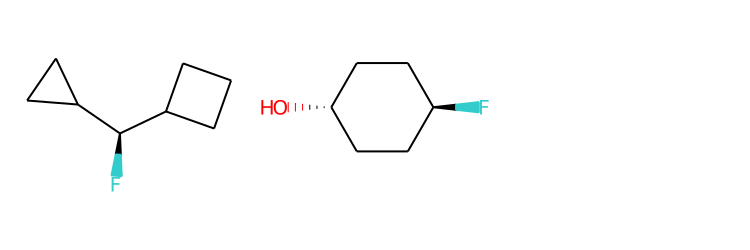

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw

m1 = Chem.MolFromSmiles('C1CC1[C@H](F)C1CCC1')
m2 = Chem.MolFromSmiles('F[C@H]1CC[C@H](O)CC1')
Draw.MolsToGridImage((m1,m2), subImgSize=(250,250))